In [1]:
%pip install pillow
%pip install numpy
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import display

# First step - Single image

In [3]:
from PIL import Image,ImageDraw;

# The core structure
img = Image.new("RGB",(128,128),color= "white")

In [4]:
# Object that can be printed out
draw = ImageDraw.Draw(img)


draw.circle((64,64),radius=30,fill="black")

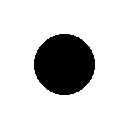

In [5]:
display(img)

# Second step - Make a bunch of random image

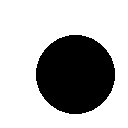

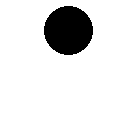

[None, None]

In [6]:
import random

l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    # Stay in side
    radius = random.randint(10,40)
    # For now we ensure the shape is inside the canva
    center = (random.randint(radius,128-radius),random.randint(radius,128-radius))
    draw.circle(xy=center,radius=radius,fill="black")
    l.append(img)
    img.save(f"data/train/circles/{i}.png")

[display(img) for img in l[50:52]]


In [7]:
l = []
for i in range(5000):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    points = [
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
]
    draw.polygon(points,fill="black")
    l.append(img)
    img.save(f"data/train/triangles/{i}.png")

# Third make the model


# 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
    

In [9]:
# A nice way to get the accelerato (whonever is training)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class ShapeCNN(nn.Module):
    # Define the layers of the neural net
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride = 1,padding=1)


        # Diminish our image size by 2, note that does make it so it need to be divisible by 2 our input
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        #  Convert our bias and weight that we got from the neurons into a 256 a number utilized mostly due to convenicnce
        # So we dont have overfitting, this applies an afiine linear transformation which is in summary
        # A fancy way transformation of our previous vector into another vector, which follows a series of guidelines
        self.fc1 = nn.Linear(in_features=(64*16*16),out_features=256)
        self.fc2 = nn.Linear(256,2)



    # How tensors are treated as we move along the net neurons
    def forward(self,x):
        # Here we are in summary ignoring negative values and making positive values variant
        # A good metaphor is thinking that we are only getting the good tastes and not the bad ones
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)


        # This immediatelly creates the layer and inputs the x given by our neurons layers
        x = nn.Flatten()(x)


        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x 

    

# A nice way to see my model layers
model = ShapeCNN().to(device)
model

Using cuda device


ShapeCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

# Step 4 - Get my training data into the model

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [11]:

transform = transforms.ToTensor()
train_dataset = datasets.ImageFolder("data/train",transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: data/train
    StandardTransform
Transform: ToTensor()

In [12]:
train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)

In [13]:
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# Notice how we have inherited labels according to our previous folder division
print(train_labels.tolist()[:5])


Feature batch shape: torch.Size([64, 3, 128, 128])
Labels batch shape: torch.Size([64])
[0, 0, 0, 0, 1]


In [14]:

batch_size = 64

def train_loop(model, train_loader,loss_fn,optimizer):
    size = len(train_loader.dataset)
    # You need to tell the model he is in training mode
    model.train()
    for batch,(images,labels) in enumerate(train_loader):
        # Mode the data into the device
        images = images.to(device)
        labels = labels.to(device)

        # Attempt at predict - Learning part
        pred = model(images)
        loss = loss_fn(pred,labels)
        # Backpropagate - THE CHAIN RULE
        loss.backward()
        # Applies the gradients found by backpropagation
        optimizer.step()
        # Reset to not resum
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss = loss.item()
            at = batch* batch_size
            print(f"Your current loss {loss:>7f} at {at} size {size}")            


In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
train_loop(model=model,train_loader=train_loader,loss_fn = loss_fn,optimizer = optimizer)

Your current loss 0.697276 at 0 size 10000
Your current loss 0.673998 at 640 size 10000
Your current loss 0.572421 at 1280 size 10000
Your current loss 0.321899 at 1920 size 10000
Your current loss 0.472094 at 2560 size 10000
Your current loss 0.453826 at 3200 size 10000
Your current loss 0.363252 at 3840 size 10000
Your current loss 0.254466 at 4480 size 10000
Your current loss 0.282136 at 5120 size 10000
Your current loss 0.182660 at 5760 size 10000
Your current loss 0.252000 at 6400 size 10000
Your current loss 0.171288 at 7040 size 10000
Your current loss 0.076132 at 7680 size 10000
Your current loss 0.181925 at 8320 size 10000
Your current loss 0.045731 at 8960 size 10000
Your current loss 0.629488 at 9600 size 10000


# Step 5 - Testing part


In [16]:
l = []
for i in range(500):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    points = [
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
    (random.randint(10, 118), random.randint(10, 118)),
]
    draw.polygon(points,fill="black")
    l.append(img)
    img.save(f"data/test/triangles/{i}.png")

In [17]:
for i in range(500):
    img = Image.new("RGB",(128,128),"white")
    draw = ImageDraw.Draw(img)
    # Stay in side
    radius = random.randint(10,40)
    # For now we ensure the shape is inside the canva
    center = (random.randint(radius,128-radius),random.randint(radius,128-radius))
    draw.circle(xy=center,radius=radius,fill="black")
    l.append(img)
    img.save(f"data/test/circles/{i}.png")

In [18]:
transform = transforms.ToTensor()
test_dataset = datasets.ImageFolder("data/test",transform=transform)
test_loader = DataLoader(test_dataset,batch_size=64,shuffle=True)

In [19]:
def eval_loop(test_loader,model,loss_fn):
    model.eval()
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    # Ensures we dont change the gradients while testing
    with torch.no_grad():
        test_loss, correct = 0, 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
test_loop(test_loader=test_loader,model=model,loss_fn=loss_fn)

NameError: name 'test_loop' is not defined

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(model=model,train_loader=train_loader,loss_fn = loss_fn,optimizer = optimizer)
    eval_loop(test_loader=test_loader,model=model,loss_fn=loss_fn)
print("Done!")

Epoch 1
-------------------------------
Your current loss 0.000038 at 0 size 10000
Your current loss 0.000074 at 640 size 10000
Your current loss 0.000025 at 1280 size 10000
Your current loss 0.000050 at 1920 size 10000
Your current loss 0.000081 at 2560 size 10000
Your current loss 0.000028 at 3200 size 10000
Your current loss 0.000240 at 3840 size 10000
Your current loss 0.000042 at 4480 size 10000
Your current loss 0.000017 at 5120 size 10000
Your current loss 0.000030 at 5760 size 10000
Your current loss 0.000053 at 6400 size 10000
Your current loss 0.000051 at 7040 size 10000
Your current loss 0.000047 at 7680 size 10000
Your current loss 0.000008 at 8320 size 10000
Your current loss 0.000025 at 8960 size 10000
Your current loss 0.000055 at 9600 size 10000
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.004738 

Epoch 2
-------------------------------
Your current loss 0.000039 at 0 size 10000
Your current loss 0.000099 at 640 size 10000
Your current loss 0.000216 at 1280 size 10000
Yo

# Okay i am relatively happy with what we got lets throw this in to python as I am having a hard time tracking stuff, also lets try pytorch ignite to select the best moment of our epochs